In [1]:
import gdown
import pims
import torch as tr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from omegaconf import OmegaConf
import os
os.environ["VRE_DEVICE"] = "cuda"

from vre import VRE
from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root, image_read, collage_fn, image_write

%load_ext autoreload
%autoreload 2

In [2]:
def dwd_video_if_needed() -> str:
    """download the video in the resources dir if not exist and return the path"""
    video_path = get_project_root() / "resources/testVideo.mp4"
    if not video_path.exists():
        video_path.parent.mkdir(exist_ok=True, parents=True)
        gdown.download("https://drive.google.com/uc?id=158U-W-Gal6eXxYtS1ca1DAAxHvknqwAk", f"{video_path}")
    return f"{video_path}"
video = pims.Video(pth := dwd_video_if_needed())
video.file = pth
print(video)

<FramesSequenceND>
Axes: 3
Axis 'x' size: 1280
Axis 'y' size: 720
Axis 't' size: 9021
Pixel Datatype: uint8


In [3]:
# device = "cuda" if tr.cuda.is_available() else "cpu"
# all_representations_dict: dict[str, dict] = {
#     "rgb": {"type": "default", "name": "rgb", "dependencies": [], "parameters": {}, "vre_parameters": {}},
#     "opticalflow raft": {"type": "optical-flow", "name": "raft", "dependencies": [],
#                          "parameters": {"inference_height": 360, "inference_width": 640,
#                                         "small": False, "iters": 20},
#                          "vre_parameters": {"device": device}},
#     "depth odoflow (raft)": {"type": "depth", "name": "odo-flow", "dependencies": ["opticalflow raft"],
#                              "parameters": {"linear_ang_vel_correction": True, "focus_correction": True,
#                                             "sensor_fov": 75, "sensor_width": 3840, "sensor_height": 2160,
#                                             "min_depth_meters": 0, "max_depth_meters": 400},
#                              "vre_parameters": {"velocities_path": "DJI_0956_velocities.npz"}},
# }

all_representations_dict = OmegaConf.load(open(Path.cwd() / "cfg.yaml", "r")).representations
representations = build_representations_from_cfg(all_representations_dict)
print(representations)

[2024-10-02T13:54:38 VRE-DEBUG] Doing topological sort... (build_representations.py:build_representations_from_cfg:109)
[2024-10-02T13:54:38 VRE-INFO] Building 'depth'/'dpt' (vre name: depth_dpt) (build_representations.py:build_representation_from_cfg:87)


[2024-10-02T13:54:42 VRE-INFO] Explicit VRE parameters provided to 'depth_dpt' (build_representations.py:build_representation_from_cfg:93)
[2024-10-02T13:54:42 VRE-INFO] Building 'optical-flow'/'raft' (vre name: opticalflow_raft) (build_representations.py:build_representation_from_cfg:87)
[2024-10-02T13:54:42 VRE-INFO] Explicit VRE parameters provided to 'opticalflow_raft' (build_representations.py:build_representation_from_cfg:93)
[2024-10-02T13:54:42 VRE-INFO] Building 'semantic-segmentation'/'mask2former' (vre name: mask2former_coco_swin) (build_representations.py:build_representation_from_cfg:87)
/home/mihai/code/ml/video-representations-extractor/vre/representations/semantic_segmentation/mask2former/mask2former_impl/modeling/pixel_decoder/msdeformattn.py:310: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/home/mihai/code/ml/video-representations-extractor/vre/representations/sem

{'depth_dpt': [Representation] DepthDpt(depth_dpt), 'opticalflow_raft': [Representation] FlowRaft(opticalflow_raft), 'mask2former_coco_swin': [Representation] Mask2Former(mask2former_coco_swin), 'mask2former_mapilary_r50': [Representation] Mask2Former(mask2former_mapilary_r50), 'fastsam_x': [Representation] FastSam(fastsam_x), 'fastsam_s': [Representation] FastSam(fastsam_s), 'opticalflow_rife': [Representation] FlowRife(opticalflow_rife), 'edges_dexined': [Representation] DexiNed(edges_dexined), 'softseg_gb': [Representation] GeneralizedBoundaries(softseg_gb), 'rgb': [Representation] RGB(rgb), 'normals svd (rife)': [Representation] DepthNormalsSVD(normals svd (rife))}


In [4]:
vre = VRE(video, representations)
output_dir = Path.cwd() / "here"
print(vre)
start_frame = np.random.randint(0, len(video) - 5)
end_frame = start_frame + 1
res = vre.run(output_dir=output_dir, start_frame=start_frame, end_frame=end_frame, batch_size=1,
              output_dir_exist_mode="skip_computed")
display(res)

VRE (11 representations). Video: '/home/mihai/code/ml/video-representations-extractor/resources/testVideo.mp4' ((9021, 720, 1280, 3))


[2024-10-02T13:54:48 VRE-INFO] 
  - Video path: '/home/mihai/code/ml/video-representations-extractor/resources/testVideo.mp4'
  - Output dir: '/home/mihai/code/ml/video-representations-extractor/examples/notebooks/here' (exist mode: 'skip_computed')
  - Representations (11): depth_dpt, opticalflow_raft, mask2former_coco_swin, mask2former_mapilary_r50, fastsam_x, fastsam_s, opticalflow_rife, edges_dexined, softseg_gb, rgb, normals svd (rife)
  - Video shape: (9021, 720, 1280, 3) (FPS: 29.97)
  - Output frames (1): [1737 : 1737]
  - Output shape: (720, 1280)
  - Batch size: 1
  - Export npy: True
  - Export png: True
  - Exception mode: 'stop_execution'
  - Thread pool workers for storing data (0 = using main thread): 0
 (vre_runtime_args.py:_print_call:90)
[2024-10-02T13:54:48 VRE-DEBUG] [DataStorer] Set up with 0 threads. (data_storer.py:__init__:22)
[2024-10-02T13:54:48 VRE-INFO] Loading weights from '/home/mihai/code/ml/video-representations-extractor/weights/depth_dpt_midas.pth' (de

,depth_dpt,opticalflow_raft,mask2former_coco_swin,mask2former_mapilary_r50,fastsam_x,fastsam_s,opticalflow_rife,edges_dexined,softseg_gb,rgb,normals svd (rife)
1737,2.434206,1.084311,3.820341,1.771015,3.816543,2.507878,0.334176,2.209879,0.566816,0.039719,2.494855


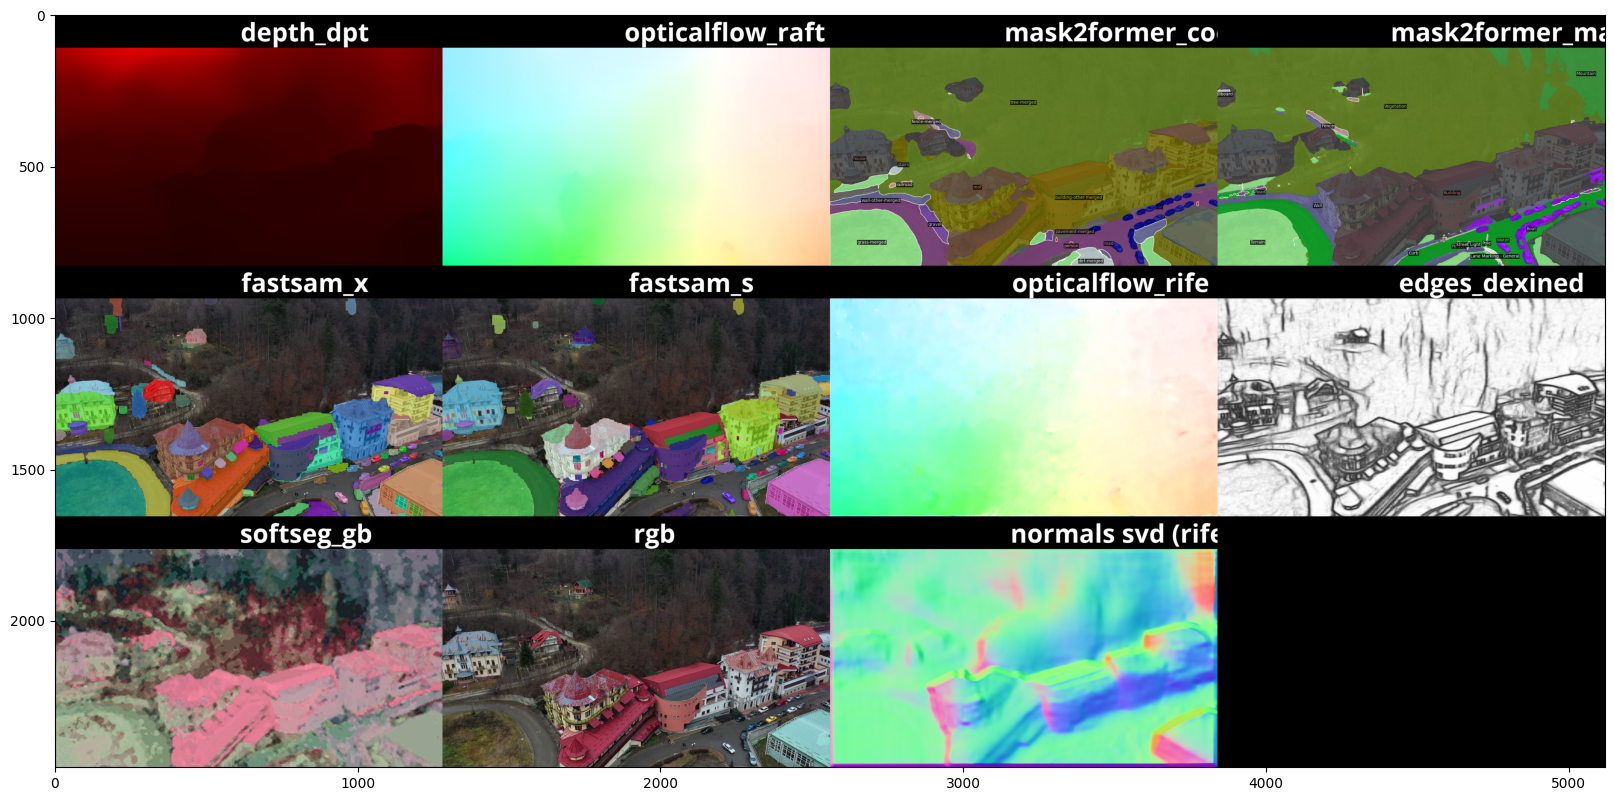

In [5]:
frames = [x.name for x in Path(output_dir / "rgb/png").iterdir()]
start_frame = np.random.permutation(frames)[0]
imgs = [image_read(output_dir / r / "png" / start_frame) for r in vre.representations]
collage = collage_fn(imgs, titles=vre.representations, size_px=70)
image_write(collage, f"collage_{start_frame}")
plt.figure(figsize=(20, 10))
plt.imshow(collage)

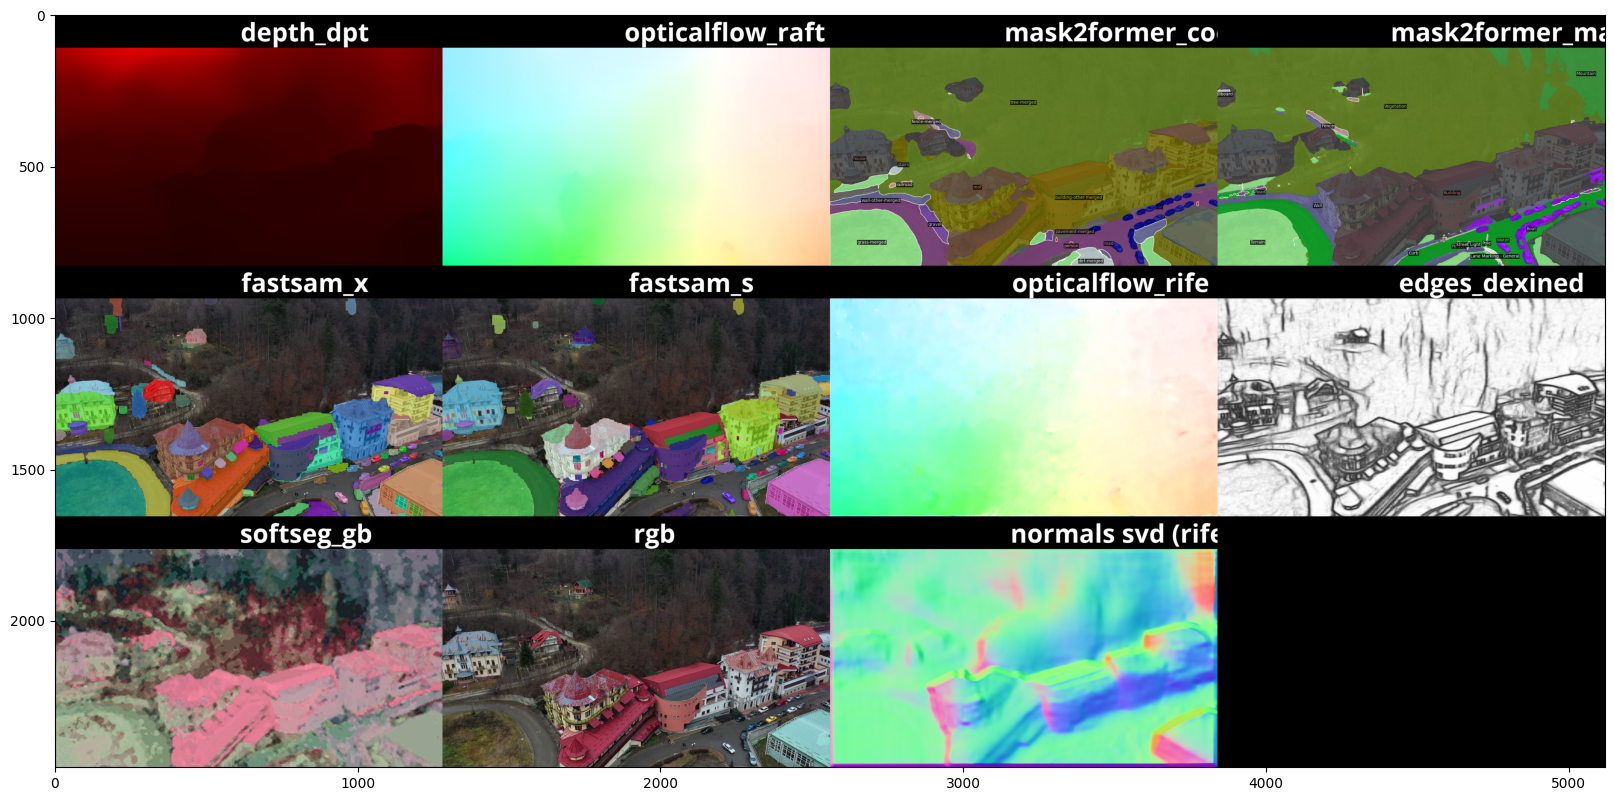

In [6]:
frames = [x.name for x in Path(output_dir / "rgb/png").iterdir()]
start_frame = np.random.permutation(frames)[0]
imgs = [image_read(output_dir / r / "png" / start_frame) for r in vre.representations]
collage = collage_fn(imgs, titles=vre.representations, size_px=70)
image_write(collage, f"collage_{start_frame}")
plt.figure(figsize=(20, 10))
plt.imshow(collage)